In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# Tripolar grid

Definitions and constructing formulas for a bipolar grid from Murray's 1996 paper (R.J. Murray, Explicit Generation of Orthogonal Grids for Ocean Models, Journal of Computational Physics 126, 251-273 (1996))

Points on the grid sphere 

$\lambda_c$ and $\phi_c$ are the longitude and latitude of the point X on the spherical grid.

$\lambda_s$ and $\phi_s$ are the longitude and latitude of the point X on the projected-re-projected bipolar grid.

$\Phi_P$    is the latitude of the bounding parallel of bipolar grid (tripolar N cap).

$\lambda_0$ is the longitude of the rotated (bipolar) equator (longitude of the displaced pole).

In [10]:
#General imports and definitions
import numpy as np
import matplotlib.pyplot as plt
PI_180 = np.pi/180.

#utility function to plot grids 
def plot_grid(lon_grid,lat_grid, grid_x,grid_y,lon0=0,lat0=0,dlon=20,dlat=20,coastline=False):
    from mpl_toolkits.basemap import Basemap
    import matplotlib
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,7))
    # You can set negative contours to be solid instead of dashed:
    matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
    # setup north polar stereographic basemap.
    # The longitude lon_0 is at 6-o'clock, and the
    # latitude circle boundinglat is tangent to the edge
    # of the map at lon_0. Default value of lat_ts
    # (latitude of true scale) is pole.
    map = Basemap(projection='npstere',boundinglat=lat0,lon_0=lon0,resolution='l')
    mx,my = map(lon_grid,lat_grid)
    #print(np.shape(x), np.shape(y)) #(239, 2881) (239, 2881)
    cs_x = map.contour(mx,my, grid_y,colors='k',linewidths=1.0, levels=np.arange(lat0, 90, dlon))
    cs_y = map.contour(mx,my, grid_x,colors='r',linewidths=1.0, levels=np.arange(lon0, lon0+360, dlat))
    plt.clabel(cs_y, inline=1, fontsize=10)
    plt.clabel(cs_x, inline=1, fontsize=10)
    if(coastline) :
        map.drawcoastlines()   

def atan2(x,y):
    angle = np.arctan( x / y )
    angle2 = np.where( x>0, angle+np.pi, angle-np.pi )
    return np.where( y>0, angle, angle2)

def mdist(x1,x2):
  """Returns positive distance modulo 360."""
  a=np.mod(x1-x2+720.,360.)
  b=np.mod(x2-x1+720.,360.)
  d=np.minimum(a,b)
  return d

def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r'):
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color)
#plot_mesh_in_latlon(lams,phis,stride=16)
def plot_mesh_in_xyz(lam, phi, stride=1, phi_color='k', lam_color='r'):
    x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
    y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
    z = np.sin(phi*PI_180)
    plot_mesh_in_latlon(x, y, stride=stride, phi_color=phi_color, lam_color=lam_color)
#plt.figure(figsize=(6,6))
#plot_mesh_in_xyz(lams, phis, stride=20)

In [2]:
#tripolar grid quantities
refine=2  # Set to 2 for GIS_025 grid and 4 for GIS_0125
lon_p=-300. # longitude of the displaced pole(s)
lat_p=61.247692871618455 #mercator.y.max()
lenlon=360. 
lenlat=90.0-lat_p
nxtot=1440*refine
ny_ncap=119*refine

In [12]:
#Definitions:

lon_p=-300. # longitude of the bipole(s)
lat_p=61.247692871618455 #mercator.y.max() #latitude of the bipole(s)

#Define a (lon,lat) coordinate on the Northern cap of the Earth sphere
lenx_cap=360. 
leny_cap=90.0-lat_p
nx_cap=1440*refine
ny_cap=119*refine
sp_lon_cap = lon_p + np.arange(nx_cap+1) * lenx_cap/nx_cap 
sp_lat_cap = lat_p + np.arange(ny_cap+1) * leny_cap/ny_cap
lam_cap = np.tile(sp_lon_cap,(ny_cap+1,1)) 
phi_cap = np.tile(sp_lat_cap.reshape((ny_cap+1,1)),(1,nx_cap+1)) 
print("lam_cap.start",lam_cap[0,0],"lam_cap.shape",lam_cap.shape) #(239, 2881)
print("phi_cap.start",phi_cap[0,0],"phi_cap.shape",phi_cap.shape) #(239, 2881)

#Define a (lon,lat) coordinate on the Northern hemisphere of the globe sphere
nxg=1440*refine
nyg=119*refine
long0=lon_p #strat the longitude of the grid from the desired longitude of the bipole(s)      
latg0=0.
lengx=360. 
lengy=90.

#nyg = nyg*int(lengy/(leny_cap))

sp_long = long0 + np.arange(nxg+1) * lengx/nxg 
sp_latg = latg0 + np.arange(nyg+1) * lengy/nyg
lamg = np.tile(sp_long,(nyg+1,1)) 
phig = np.tile(sp_latg.reshape((nyg+1,1)),(1,nxg+1)) 
print("lamg.start",lamg[0,0],"lamg.shape",lamg.shape) #(239, 2881)
print("phig.start",phig[0,0],"phig.shape",phig.shape) #(239, 2881)



lam_cap.start -300.0 lam_cap.shape (239, 2881)
phi_cap.start 61.247692871618455 phi_cap.shape (239, 2881)
lamg.start -300.0 lamg.shape (239, 2881)
phig.start 0.0 phig.shape (239, 2881)


## MIDAS

### MIDAS call

In [8]:
from pymidas.rectgrid_gen import supergrid
tripolar_n=supergrid(nxtot,ny_ncap,'spherical','degrees',lat_p,lenlat,lon_p,lenlon,tripolar_n=True)
tripolar_n.grid_metrics()
tripolar_n.write_nc('ncap_supergrid.nc')
print ("generated a tripolar supergrid of size (ny,nx)= ",tripolar_n.y.shape[0]-1,tripolar_n.y.shape[1]-1)
print ("tripolar grid starting longitude = ",tripolar_n.x[0,0])
print ("tripolar grid starting latitude = ",tripolar_n.y[0,0])
print (np.shape(tripolar_n.x) , np.shape(tripolar_n.y))

generated a tripolar supergrid of size (ny,nx)=  238 2880
tripolar grid starting longitude =  -300.0
tripolar grid starting latitude =  61.24769287161847
(239, 2881) (239, 2881)


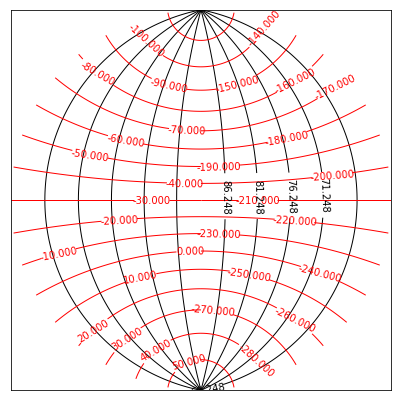

In [16]:
plot_grid(tripolar_n.x, tripolar_n.y, lam_cap,phi_cap,lon0=lon_p, lat0=lat_p, dlat=10, dlon=5)

### MIDAS algorithm based on Murray 96

$\lambda_c$ and $\phi_c$ are longitude and latitude of the point X on the spherical grid.

$\lambda_s$ and $\phi_s$ are longitude and latitude of the point X on the projected-re-projected dipolar grid.

$\Phi_P$ is  the latitude of the bounding parallel of the tripolar cap.

$\lambda_0$ is the longitude of the rotated (bipolar) equator (i.e., the longitude of the displaced pole).

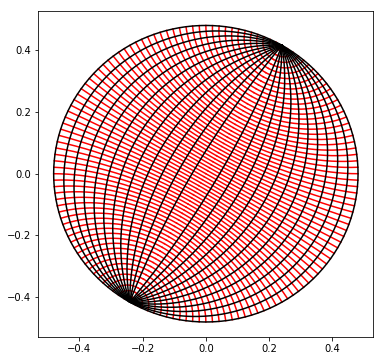

In [30]:

rp_M=np.tan(0.5*(0.5*np.pi - (sp_grid_y[0])*PI_180)) #Murray section 2.2 before Eq(6) r_p=tan(\phi_P\prime /2) 
                                                   #where \phi_P is the latitude of the bounding parrallel lat0
##MIDAS lon,lat=self.tp_trans():
##MIDAS lamc=self.bp_lon() #Why is this lon?
chi_M=2.0*np.arctan(np.tan(0.5*(0.5*np.pi-sp_grid_y*PI_180))/rp_M) #Murray Inverse of Eq(5b) 
#lamc = 0.5*np.pi - chi  #Why??????????
#lamc[:,:(nxtot//2)] = lamc[:,:(nxtot//2)] - np.pi/2
#lamc[:,(nxtot//2):] =-lamc[:,(nxtot//2):] + np.pi/2
#OR equivalently
lamc_M = - chi_M  #Why??????????
lamc_M[:,:(nxtot//2)] =  lamc_M[:,:(nxtot//2)] 
lamc_M[:,(nxtot//2):] =- lamc_M[:,(nxtot//2):] 
##phic=self.bp_colat() #Why is this co-lat in  MIDAS?
phic_M=mdist(sp_grid_x,lon_p) *PI_180
##phic=(sp_grid_x-lon0) *PI_180 
chic_M =np.arccos(np.sin(phic_M)*np.cos(lamc_M))    #Murray Eq(6) assuming phic is 90-phic !! ***********??
#chic =np.arccos(np.cos(phic)*np.cos(lamc))    #Murray Eq(6) the grid does not make sense !!
phis_M = 90 - np.arctan(rp_M*np.tan(chic_M/2.0)) * 2/PI_180 #Murray Eq(5b) for \phi_s
lams_M = np.arctan(np.tan(phic_M)*np.sin(lamc_M)) /PI_180   #Murray part of Eq(5a)  assuming phic is 90-phic !!
#The following gymnastics in Midas is missing from Murray paper. 
#Does this accomplish 90-atan(sin(\lambda_c)tan(\phi_c))?
lams_M[:,:nxtot//4]=-lams_M[:,:nxtot//4]
lams_M[:,nxtot//4]=90.0
lams_M[:,nxtot//4+1:nxtot//2]=180.0-lams_M[:,nxtot//4+1:nxtot//2]
lams_M[:,nxtot//2]=180.
lams_M[:,nxtot//2+1:3*nxtot//4]=180.0-lams_M[:,nxtot//2+1:3*nxtot//4]
lams_M[:,3*nxtot//4]=270.
lams_M[:,3*nxtot//4+1:]=360.-lams_M[:,3*nxtot//4+1:]
lams_M = lams_M + lon_p #Murray part of Eq(5a)  

#plot_grid( lams_M,phis_M, lam_cap,phi_cap,lon0=lon_p, lat0=lat_p, dlat=10, dlon=5)
plt.figure(figsize=(6,6))
plot_mesh_in_xyz(lams_M, phis_M, stride=20)

### Alternative to Murray 96 


Here we construct the bipolar cap grid using a geometric method different from but inspired by Murray96.

First consider a globe of radius $r$ with the regular lon,lat grid but the grid circles rotated by 90 degrees around an axis that crosses the equator at the longitude $\lambda_P+90$, where $\lambda_P$ is the desired longitude of the displaced bi-poles (-300 in MIDAS construction). We denote these sets by $\Lambda_g$ and  $\Phi_g$.

Next we do a stereographic projection $P_r$ of the these two sets of circles onto a plane tangent at the North pole. The resulting two sets of curves form a curvilinear orthogonal coordinate patch for the globe with two poles located at the equator with longitudes $\lambda_P$ and$\lambda_P+180$. We denote these sets by $\Lambda_c$ and  $\Phi_c$.

Finally we do an inverse stereographic projection $P_R^{-1}$ of these curvilinear coordinate curves back on a sphere with a larger radius $R$ to relocate the poles to the desired latitude of the bipolar grid $\phi_P$. We denote these sets by $\Lambda_s$ and  $\Phi_s$, they form the desired orthogonal bipolar coordinate patch for the North cap.

So, schematically: $(\Lambda_s,\Phi_s) = P_R^{-1}(\Lambda_c,\Phi_c)=P_R^{-1}(P_r(\Lambda_g,\Phi_g)))$

The equations for the globe circles in part (1) are obtained as follows:
 
Assume a simple lon,lat coordinates on the globe:

\begin{align}
\lambda_g &= \lambda_p + i {360\over N_x} \\
\phi_g    &= j {180\over N_y}
\end{align}

 
  $\Lambda_g$ : The set of great circles with the common axis that crosses the equator at longitude $\lambda_P$. These are formed by the intersection of planes through origin with unit normal vectors ${\bf u} = ( 0,\sin\phi_g , \cos\phi_g)$ and the globe, where $\phi_g$ is the angle between ${\bf u}$ and y axis assuming we set $x$ axis in the direction of $\lambda_P$. So they obey ${\bf u} {\bf .}  (\cos\phi \cos(\lambda-\lambda_P),\cos\phi \sin(\lambda-\lambda_P),\sin\phi )=0$ which gives: 
  
\begin{align}  
\tan\phi=-\tan\phi_g \sin(\lambda-\lambda_P).
\end{align}
  
 $\Phi_g$ : The set of parallel circles with the same axis as above. 
These are formed by the intersection of planes perpendicular to the axis of the great circles above with unit normal vectors ${\bf u} = ( 1, 0, 0)$ and the globe, we set $x$ axis in the direction of $\lambda_P$. So, they obey:

\begin{align} 
\cos\phi \cos(\lambda-\lambda_P) = \cos(\lambda_g-\lambda_P).
\end{align}

The curvilinear coordinate patch $(\lambda_c,\phi_c)$ is obtained by solving the above two equations simultaneously: 

\begin{align}
\frac{\sin(\lambda_c-\lambda_P)}{\tan\phi_c} &= -\frac{1}{\tan\phi_g}      \equiv \beta  \label{eq:beta} \\
{\cos(\lambda_c-\lambda_P) \cos\phi_c}       &=  \cos(\lambda_g-\lambda_P)\equiv  \alpha \label{eq:alpha}
\end{align}

which gives:

\begin{align}
 \phi_c &= \sin^{-1}\left[ \left(\frac{1-\alpha^2}{1+\beta^2}\right)^{1/2} \right]\\
 \lambda_c &= \sin^{-1}\left[ \left(\beta^2\frac{1-\alpha^2}{\alpha^2+\beta^2} \right)^{1/2} \right]
\end{align}

Note that because of the square roots in the above equations the signs have to be chosen so that the solution remains continuous.
Now to achieve the inverse projection we only need to observe a simple relation between the angels in the geometric construction (we need a figure to show this): 

\begin{align}
\tan(\frac{(90-\phi_s)}{2}) &= \tan(\frac{(90-\phi_P)}{2}) \tan(\frac{(90-\phi_c)}{2})\\
\lambda_s &= \lambda_c
\end{align}

and so:

\begin{align}
\phi_s &= 90 - 2 \tan^{-1}\left( r_p \tan(\frac{(90-\phi_c)}{2}) \right) ; \ \ r_p \equiv \tan(\frac{(90-\phi_P)}{2}) \label{eq:phis} \\
\lambda_s &= \lambda_c
\end{align}


### Compare with Murray 96

The above equation\eqref{eq:phis} would be identical to Murray's Eq(5b) if we assume $\chi_c = 90-\phi_c$. But then Murray's Eq(6) $\cos\chi_c = \cos\lambda_c \cos\phi_c$, would be in conflict with that assumption (relates $\phi_c$ to $\lambda_c$)! On the other hand Murray's Eq(6) is somewhat similar to the equation \eqref{eq:alpha} above if we assume $\chi_c=\lambda_g-\lambda_P$, which would then be in apparent conflict with equation\eqref{eq:phis} above. 

Murray's Eq(5a) is similar to equation\eqref{eq:beta} above if we assume that $\lambda_s-\lambda_P=\phi_g$, which is again in apparent conflict with all other equations.

Moreover in MIDAS (and FMS) implementation $\lambda_c$ and $phi_c$ are derived from $\phi_g$ and $\lambda_g$ respectively, contrary to the intuition ($\lambda_c$ is derived via solving Murray's Eq(5a) for $\lambda_c$ at $\phi_c=0$ given $\lambda_s=\phi_g$ and \phi_c is set to $90-\lambda_g$.) 

All these conflicts point to a subtle switching of the roles of latitude and longitude at the connection line in the transformation defined in Murray which he mentions only in passing at section 2.2. 

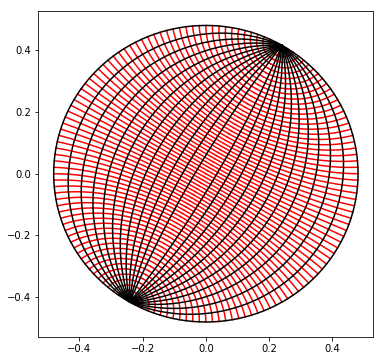

In [28]:
rp=np.tan(0.5*(90-lat_p)*PI_180)

#Simplify  the formulas to avoid division by zero
alpha  = np.cos((lamg-lon_p)*PI_180) 
#alpha  = alpha / np.cos((phig)*PI_180)
#alpha = np.where((lamg-lon_p<180),-np.tanh((lamg-lon_p-90)*PI_180),np.tanh((lamg-lon_p-270)*PI_180))
alpha2 = alpha**2
#beta = -np.cotan(phig*PI_180)
beta2_inv = (np.tan(phig*PI_180))**2
#beta2_inv = beta2_inv/(1-alpha2)
#A=np.sqrt((1-alpha2)/(1+beta**2)) #Actually two equations  +- |A|
A=np.sqrt(1-alpha2)*np.sin(phig*PI_180)
#B=np.sqrt(beta**2 * (1-alpha**2)/(alpha**2+beta**2))  #Actually two equations  +- |B|
B=np.sqrt((1-alpha2)/(1+alpha2*beta2_inv))

phic = np.arcsin(A)/PI_180
lamc = np.arcsin(B)/PI_180 

chic = np.arccos(A)

##But this equation accepts 4 solutions for a given B, {l, 180-l, l+180, 360-l } 
##We have to pickup the "correct" root. 
##One way is simply to demand lamc to be continuous with lam on the equator phi=0
##I am sure there is a more mathematically concrete way to do this.
lamc = np.where((lamg-lon_p>90)&(lamg-lon_p<=180),180-lamc,lamc)
lamc = np.where((lamg-lon_p>180)&(lamg-lon_p<=270),180+lamc,lamc)
lamc = np.where((lamg-lon_p>270),360-lamc,lamc)
lamc = lamc + lon_p

#plot_grid(lamc,phic , lamg,phig,lon0=lon_p,dlon=10);

##Project back onto the larger (true) sphere so that the projected equator shrinks to latitude \phi_P=lat0_tp
##then we have tan(\phi_s'/2)=tan(\phi_p'/2)tan(\phi_c'/2)

#phis = 90 - 2 * np.arctan(rp * np.tan(0.5*(90-phic)*PI_180))/PI_180
phis = 90 - 2 * np.arctan(rp * np.tan(chic/2))/PI_180
lams = lamc

#plot_grid(lams, phis, lam_cap,phi_cap, lon0=lon_p, lat0=lat_p, dlat=10, dlon=5);
plt.figure(figsize=(6,6))
plot_mesh_in_xyz(lams, phis, stride=20)

### Explore 

This grid differs from the one generated from MIDAS. 
What is the root cause of the difference?

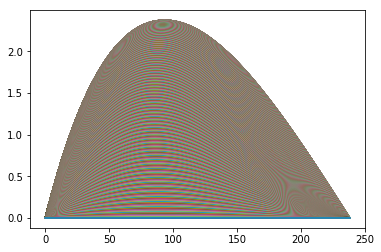

In [24]:
plt.plot(phis-tripolar_n.y);

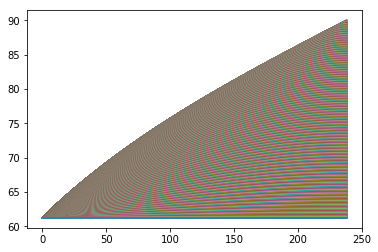

In [25]:
plt.plot(phis);

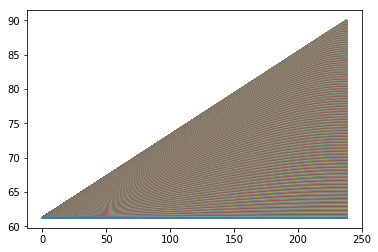

In [26]:
plt.plot(tripolar_n.y);

### FMS algorithm 

The algorithm used in FMS code is also based on Murray96 but is slightly different from MIDAS https://gitlab.gfdl.noaa.gov/fre/fre-nctools/blob/master/tools/shared/tool_util.c#L291 

/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in true_divide
/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in true_divide


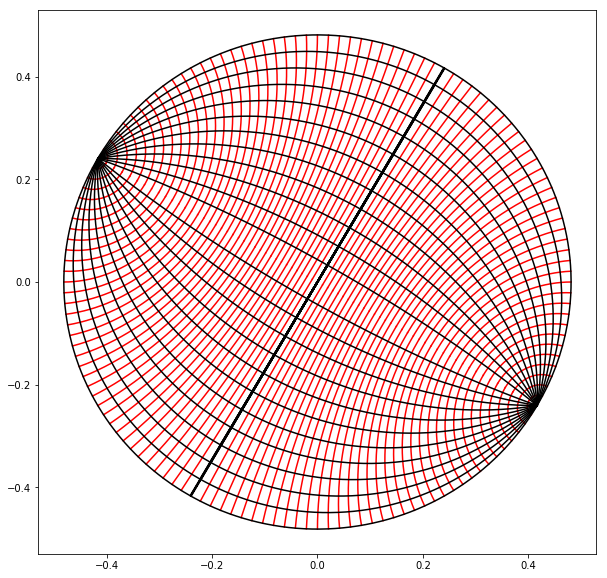

In [99]:
def mdist(x1,x2):
  """Returns positive distance modulo 360."""
  a=np.mod(x1-x2+720.,360.)
  b=np.mod(x2-x1+720.,360.)
  d=np.minimum(a,b)
  return d

def bp_lam(x,y,bpeq,rp):
    """bp_lam = ((90-y)/(90-lat_join))*90
       invert Murray's eqn. 5b with phic=0 to place point at specified geo. lat """
    bp_lam = 2.*np.arctan(np.tan((0.5*np.pi-y*PI_180)/2)/rp)/PI_180
    bp_lam = np.where(mdist(x,bpeq)<90.,-bp_lam, bp_lam)
    return bp_lam    

def bp_phi(x,y,bpsp,bpnp):
    bps = mdist(x,bpsp)
    bpn = mdist(x,bpnp)
    bp_phi = np.where(bps<90,-90+bps,90-bpn)
    return bp_phi

lamc_fms = bp_lam(lam_cap,phi_cap,lon_p+90,rp) 
phic_fms = bp_phi(lam_cap,phi_cap,lon_p,lon_p+180)

lams_fms = lon_p + 90 - atan2(np.sin(lamc_fms*PI_180),np.tan(phic_fms*PI_180))/PI_180 #eqn.5a

chic_fms = np.arccos(np.cos(lamc_fms*PI_180)*np.cos(phic_fms*PI_180)) #eqn.6
phis_fms = 90 - 2 * np.arctan(rp*np.tan(chic_fms/2))/PI_180


#plt.plot(phis_fms);
#plot_grid( lams_fms,phis_fms, lam_cap,phi_cap,lon0=lon_p, lat0=lat_p, dlat=10, dlon=5)
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lams_fms, phis_fms, stride=20)

(239, 2881)

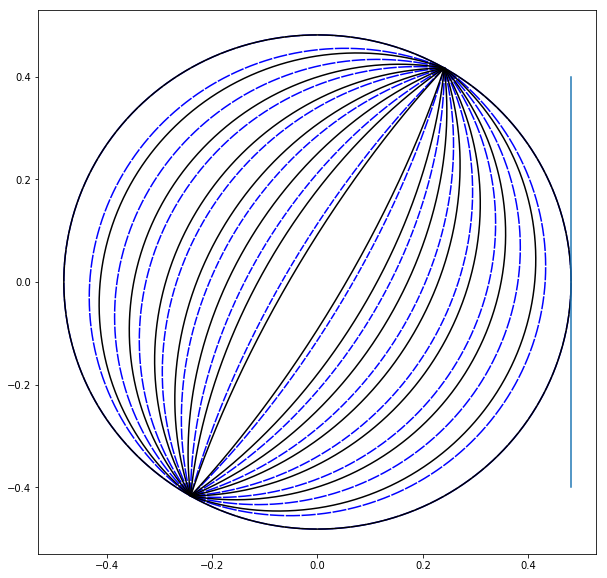

In [139]:
#Define a (lon,lat) coordinate on the Northern hemisphere of the globe sphere
nxg=1440*refine
nyg=119*refine
long0=lon_p #strat the longitude of the grid from the desired longitude of the bipole(s)      
latg0=0.
lengx=360. 
lengy=90.

#nyg = nyg*int(lengy/(leny_cap))

sp_long = long0 + np.arange(nxg+1) * lengx/nxg 
sp_latg = latg0 + np.arange(nyg+1) * lengy/nyg
lamg = np.tile(sp_long,(nyg+1,1)) 
phig = np.tile(sp_latg.reshape((nyg+1,1)),(1,nxg+1)) 



rp=np.tan(0.5*(90-lat_p)*PI_180)

#Simplify  the formulas to avoid division by zero
alpha  = np.cos((lamg-lon_p)*PI_180) 
#alpha  = alpha / np.cos((phig)*PI_180)
#alpha = np.where((lamg-lon_p<180),-np.tanh((lamg-lon_p-90)*PI_180),np.tanh((lamg-lon_p-270)*PI_180))
alpha2 = alpha**2
#beta = -np.cotan(phig*PI_180)
beta2_inv = (np.tan(phig*PI_180))**2
#beta2_inv = beta2_inv/(1-alpha2)
#A=np.sqrt((1-alpha2)/(1+beta**2)) #Actually two equations  +- |A|
A=np.sqrt(1-alpha2)*np.sin(phig*PI_180)
#B=np.sqrt(beta**2 * (1-alpha**2)/(alpha**2+beta**2))  #Actually two equations  +- |B|
B=np.sqrt((1-alpha2)/(1+alpha2*beta2_inv))

phic = np.arcsin(A)/PI_180
lamc = np.arcsin(B)/PI_180 

chic = np.arccos(A)

##But this equation accepts 4 solutions for a given B, {l, 180-l, l+180, 360-l } 
##We have to pickup the "correct" root. 
##One way is simply to demand lamc to be continuous with lam on the equator phi=0
##I am sure there is a more mathematically concrete way to do this.
lamc = np.where((lamg-lon_p>90)&(lamg-lon_p<=180),180-lamc,lamc)
lamc = np.where((lamg-lon_p>180)&(lamg-lon_p<=270),180+lamc,lamc)
lamc = np.where((lamg-lon_p>270),360-lamc,lamc)
lamc = lamc + lon_p

#plot_grid(lamc,phic , lamg,phig,lon0=lon_p,dlon=10);

##Project back onto the larger (true) sphere so that the projected equator shrinks to latitude \phi_P=lat0_tp
##then we have tan(\phi_s'/2)=tan(\phi_p'/2)tan(\phi_c'/2)

#phis = 90 - 2 * np.arctan(rp * np.tan(0.5*(90-phic)*PI_180))/PI_180
phis = 90 - 2* np.arctan(rp * np.tan(chic/2))/PI_180
lams = lamc

#plot_grid(lams, phis, lam_cap,phi_cap, lon0=lon_p, lat0=lat_p, dlat=10, dlon=5);

plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lams_M, phis_M, stride=30,phi_color='b', lam_color='w')
plot_mesh_in_xyz(lams, phis, stride=30,phi_color='k', lam_color='w')
r=np.cos(lat_p*PI_180)
plt.plot([r,r],[-0.4,0.4])
lams.shape

In [134]:
238/7

34.0

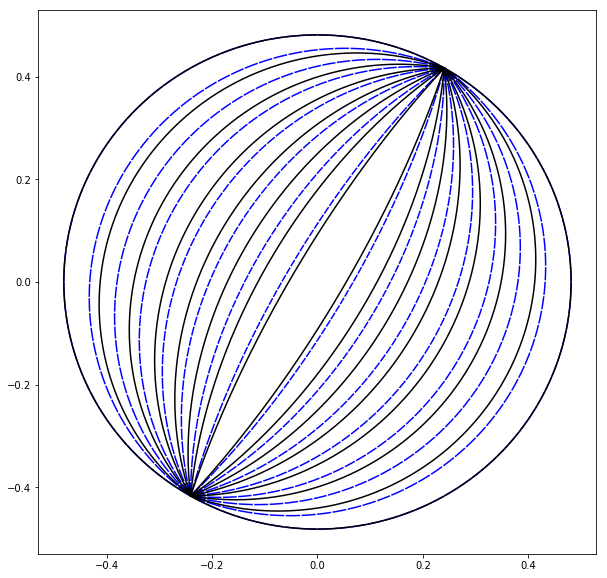

In [54]:
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lams_M, phis_M, stride=30,phi_color='b', lam_color='w')
plot_mesh_in_xyz(lams, phis, stride=30,phi_color='k', lam_color='w')

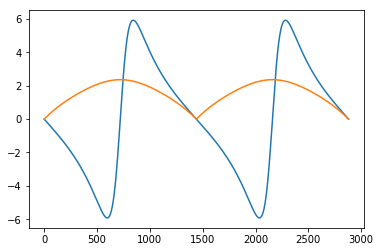

In [60]:
plt.plot(lams[200,:]-tripolar_n.x[200,:]);

plt.plot(phis[100,:]-tripolar_n.y[100,:]);

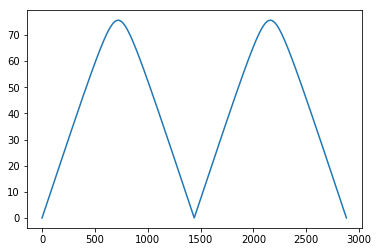

In [412]:
plt.plot(phic[200,:]);

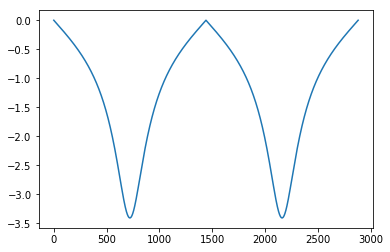

In [413]:
plt.plot(90-chic_fms[200,:]/PI_180-phic[200,:]);

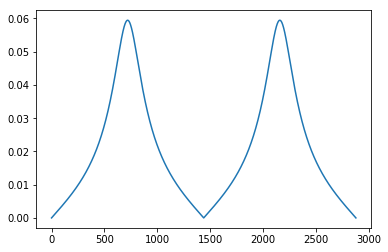

In [414]:
plt.plot(chic_fms[200,:]-chic[200,:]);

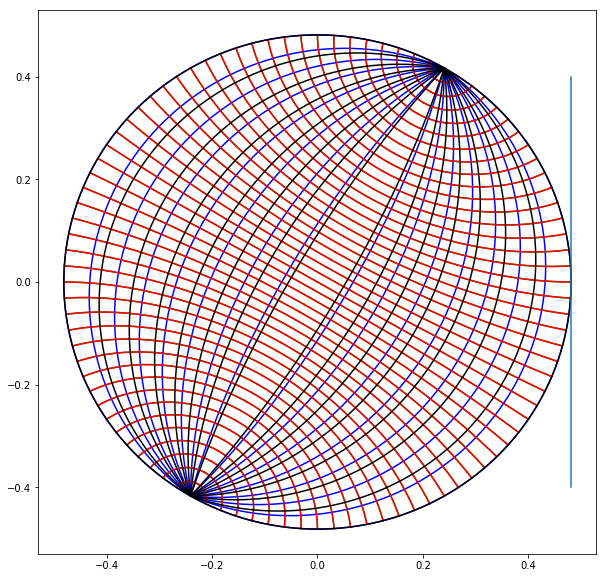

In [58]:
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lams_M, phis_M, stride=30,phi_color='b', lam_color='g')
plot_mesh_in_xyz(lams, phis, stride=30,phi_color='k', lam_color='r')
r=np.cos(lat_p*PI_180)
plt.plot([r,r],[-0.4,0.4])

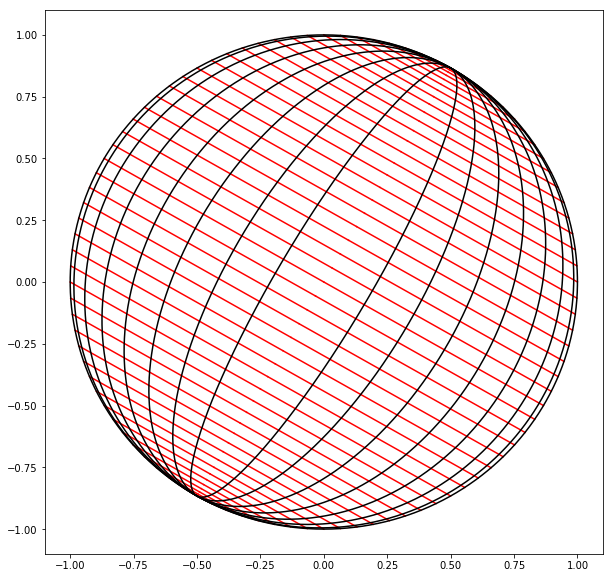

In [68]:
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lamc, phic, stride=30,phi_color='k', lam_color='r')


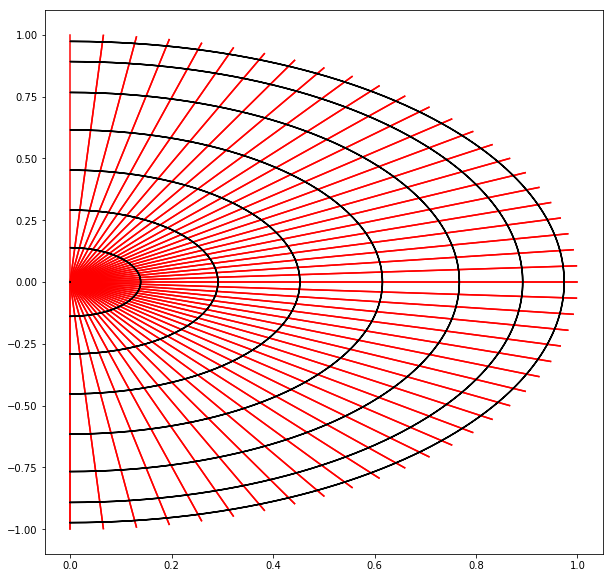

In [65]:
plt.figure(figsize=(10,10))
plot_mesh_in_xyz( phic_fms,lamc_fms, stride=30,phi_color='k', lam_color='r')


In [71]:
Re = 6.378e6

def generate_grid_metrics(x,y,axis_units='degrees'):
    nytot,nxtot = x.shape
    if  axis_units == 'm':
      metric=1.0
    if  axis_units == 'km':            
      metric=1.e3
    if  axis_units == 'degrees':                        
      metric=Re*PI_180
    ymid_j = 0.5*(y+np.roll(y,shift=-1,axis=0))
    ymid_i = 0.5*(y+np.roll(y,shift=-1,axis=1))      
    dy_j = np.roll(y,shift=-1,axis=0) - y
    dy_i = np.roll(y,shift=-1,axis=1) - y
    dx_i = mdist(np.roll(x,shift=-1,axis=1),x)
    dx_j = mdist(np.roll(x,shift=-1,axis=0),x)
    dx = metric*metric*(dy_i*dy_i + dx_i*dx_i*np.cos(ymid_i*PI_180)*np.cos(ymid_i*PI_180))
    dx = np.sqrt(dx)
    dy = metric*metric*(dy_j*dy_j + dx_j*dx_j*np.cos(ymid_j*PI_180)*np.cos(ymid_j*PI_180))
    dy = np.sqrt(dy)
    dx=dx[:,:-1]
    dy=dy[:-1,:]
    area=dx[:-1,:]*dy[:,:-1]    
    angle_dx=np.zeros((nytot,nxtot))
    angle_dx = np.arctan2(dy_i,dx_i)/PI_180      
    return dx,dy,area,angle_dx


def write_nc(x,y,dx,dy,area,angle,axis_units='degrees',fnam=None,format='NETCDF3_CLASSIC'):
    import netCDF4 as nc

    if fnam is None:
      fnam='supergrid.nc'
    f=nc.Dataset(fnam,'w',format=format)
    dims=[]
    vars=[]
    nytot,nxtot = y.shape
    nyp=f.createDimension('nyp',nytot)
    nxp=f.createDimension('nxp',nxtot)
    ny=f.createDimension('ny',nytot-1)
    nx=f.createDimension('nx',nxtot-1)    
    yv=f.createVariable('y','f8',('nyp','nxp'))
    xv=f.createVariable('x','f8',('nyp','nxp'))    
    yv.units=axis_units
    xv.units=axis_units 
    yv[:]=y
    xv[:]=x
    dyv=f.createVariable('dy','f8',('ny','nxp'))
    dyv.units='meters'
    dyv[:]=dy
    dxv=f.createVariable('dx','f8',('nyp','nx'))
    dxv.units='meters'
    dxv[:]=dx
    areav=f.createVariable('area','f8',('ny','nx'))
    areav.units='m2'
    areav[:]=area
    anglev=f.createVariable('angle_dx','f8',('nyp','nxp'))
    anglev.units='degrees'
    anglev[:]=angle            
    f.sync()
    f.close()

    


In [72]:
#generate the metrics
dxs,dys,areas,angles = generate_grid_metrics(lams,phis,axis_units='degrees')

#write the grid file
write_nc(lams,phis,dxs,dys,areas,angles,axis_units='degrees',fnam='bipolarcap_new.nc')

In [73]:
dxs_M,dys_M,areas_M,angles_M = generate_grid_metrics(lams_M,phis_M,axis_units='degrees')


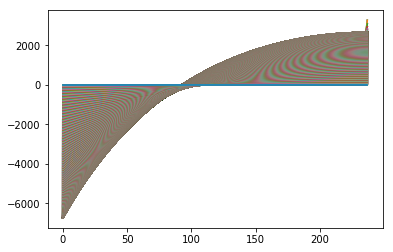

In [77]:
plt.plot(dys_M-dys);

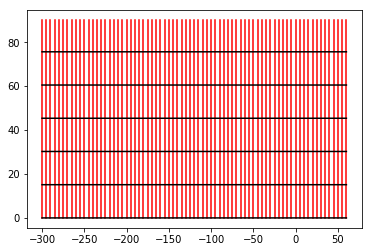

In [103]:
plot_mesh_in_latlon(lamg,phig,stride=40)

In [105]:
lamg[:,1]

array([-299.875, -299.875, -299.875, -299.875, -299.875, -299.875,
       -299.875, -299.875, -299.875, -299.875, -299.875, -299.875,
       -299.875, -299.875, -299.875, -299.875, -299.875, -299.875,
       -299.875, -299.875, -299.875, -299.875, -299.875, -299.875,
       -299.875, -299.875, -299.875, -299.875, -299.875, -299.875,
       -299.875, -299.875, -299.875, -299.875, -299.875, -299.875,
       -299.875, -299.875, -299.875, -299.875, -299.875, -299.875,
       -299.875, -299.875, -299.875, -299.875, -299.875, -299.875,
       -299.875, -299.875, -299.875, -299.875, -299.875, -299.875,
       -299.875, -299.875, -299.875, -299.875, -299.875, -299.875,
       -299.875, -299.875, -299.875, -299.875, -299.875, -299.875,
       -299.875, -299.875, -299.875, -299.875, -299.875, -299.875,
       -299.875, -299.875, -299.875, -299.875, -299.875, -299.875,
       -299.875, -299.875, -299.875, -299.875, -299.875, -299.875,
       -299.875, -299.875, -299.875, -299.875, -299.875, -299.